In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import gym_classification

In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


## Import data and scale to input 

In [3]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32)/255

In [4]:
X = x_train
y = y_train

batch_size = 100

input_shape = (X.shape[1],X.shape[2],1)

 # Initialization of the enviroment
env = gym.make('gym_classification:RLClassification-v0')

# Fill values
env.init_dataset(X,y,batch_size=batch_size,output_shape=input_shape)


# RL parameters
valid_actions = env.action_space
num_actions = valid_actions.n
epsilon = .1  # exploration
num_episodes = 5
iterations_episode = 100

decay_rate = 0.99
gamma = 0.001


# Network arquitecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                activation='relu',
                input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_actions, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])


print(model.summary())


# history saving
reward_chain = []
loss_chain = []



# Main loop
for epoch in range(num_episodes):
    loss = 0.
    total_reward_by_episode = 0
    # Reset enviromet, actualize the data batch
    states = env.reset()

    done = False

    # Define exploration to improve performance
    exploration = 1
    # Iteration in one episode
    q = np.zeros([batch_size,num_actions])
    #for i_iteration in range(iterations_episode):

    i_iteration = 0
    while not done:
        i_iteration += 1

        # get next action
        if exploration > 0.001:
            exploration = epsilon*decay_rate**(epoch*i_iteration)            

        if np.random.rand() <= exploration:
            actions = np.random.randint(0, num_actions,batch_size)
        else:
            q = model.predict(states)
            actions = np.argmax(q,axis=1)

        # apply actions, get rewards and new state
        next_states, reward, done, _ = env.step(actions)

        next_states = next_states
        
        q_prime = model.predict(next_states)

        indx = np.argmax(q_prime,axis=1)
        sx = np.arange(len(indx))
        # Update q values
        targets = reward + gamma * q[sx,indx]   
        q[sx,actions] = targets

        # Train network, update loss
        loss += model.train_on_batch(states, q)[0]

        # Update the state
        states = next_states

        total_reward_by_episode += int(sum(reward))

    if next_states.shape[0] != batch_size:
            break # finished df
    reward_chain.append(total_reward_by_episode)    
    loss_chain.append(loss)

    print("\rEpoch {:03d}/{:03d} | Loss {:4.4f} | Tot reward x episode {:03d} ".format(epoch,
          num_episodes ,loss, total_reward_by_episode))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [5]:
# Evaluate model
from sklearn.metrics import classification_report
x_test = x_test.astype(np.float32)/255
q_prime = model.predict(x_test.reshape(-1,x_test.shape[1],x_test.shape[2],1))
predictions = np.argmax(q_prime,axis=1)

In [6]:
# Print classification report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.99      0.96      0.98      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.99      0.98       892
           6       0.99      0.98      0.98       958
           7       0.97      0.98      0.98      1028
           8       0.96      0.98      0.97       974
           9       0.99      0.97      0.98      1009

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



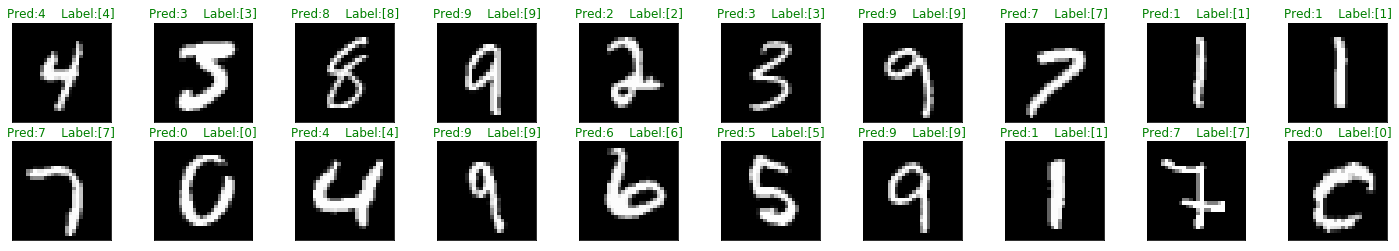

In [19]:
fig = plt.figure(figsize=(25, 4))
ran = np.random.randint(0,len(x_test),1)

for idx in np.arange(20):
    image = x_test[idx+ran,:,:].reshape(28,28)
    label = y_test[idx+ran]
    predicted = np.argmax(model.predict(x_test[idx+ran,:,:].reshape(1,28,28,1)))
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(image,cmap='gray')
    if predicted==label:
        color = 'green'
    else:
        color = 'red'
    ax.set_title(f"Pred:{predicted}    Label:{label}",color=color)